This notebook produces visualizations of the model interpretable parameters (or parameter–derived quantities) in space and time.

In [1]:
import jax
jax.config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt
plt.ioff()

In [2]:
from pathlib import Path

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cmo
import jax.numpy as jnp
from hydra_zen import instantiate, load_from_yaml
from IPython.display import HTML
from matplotlib import animation
import numpy as np
import xarray as xr
from xhistogram.xarray import histogram

from src.ec_mlp.data_driven_model import DataDrivenModel
from src.ec_mlp.drift_model import DriftModel
from src.ec_mlp.trainer_module import TrainerModule

In [3]:
ROOT = Path(".")
RUNS_DIR = ROOT / "euler_criterion/mlp/multirun/2026-02-08/09-28-33"
RUN_ID = "15"
DATA_DIR = ROOT / "data"

In [ ]:
run_cfg = load_from_yaml(RUNS_DIR / RUN_ID / ".hydra/config.yaml")

In [5]:
trunk = instantiate(run_cfg.trunk)()
physical_head = instantiate(run_cfg.physical_head)()
mdn_head = instantiate(run_cfg.mdn_head)()

In [6]:
data_driven_model = DataDrivenModel(trunk, physical_head, mdn_head)
drift_model = DriftModel(
    data_driven_model=data_driven_model, 
    stress_normalization=1.0, 
    wind_normalization=1.0,
    delta_t=1.0 * 60.0 * 60.0  # 1 hour in seconds
)

In [7]:
drift_model = TrainerModule.load_from_checkpoint(
    RUNS_DIR / RUN_ID / "best_model.ckpt", drift_model=drift_model
).drift_model

/home/bertrava/.local/share/mamba/envs/pastax_global_calibration/lib/python3.11/site-packages/lightning/pytorch/core/saving.py:96: The state dict in PosixPath('euler_criterion/mlp/multirun/2026-02-08/09-28-33/15/best_model.ckpt') contains no parameters.


In [8]:
from_datetime_str = "1994-06-01"
to_datetime_str = "2025-08-01"

In [9]:
train_ds = xr.open_zarr(DATA_DIR / f"gdp_interp_clean_{from_datetime_str}_{to_datetime_str}_train.zarr")
val_ds = xr.open_zarr(DATA_DIR / f"gdp_interp_clean_{from_datetime_str}_{to_datetime_str}_val.zarr")
test_ds = xr.open_zarr(DATA_DIR / f"gdp_interp_clean_{from_datetime_str}_{to_datetime_str}_test.zarr")

In [10]:
batch_size = 2_000_000

In [11]:
bin_size = 1  # in degree

lat_bins = np.arange(-90, 91, bin_size)
lon_bins = np.arange(-180, 181, bin_size)
lat_centers = lat_bins[:-1] + bin_size / 2
lon_centers = lon_bins[:-1] + bin_size / 2

month_bins = np.arange(1, 14)
months = np.arange(1, 13)
month_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

In [12]:
def compute_log_likelihoods(ds):
    ve = jnp.asarray(ds["ve"].values)
    vn = jnp.asarray(ds["vn"].values)
    ugos = jnp.asarray(ds["ugos"].values)
    vgos = jnp.asarray(ds["vgos"].values)
    eastward_stress = jnp.asarray(ds["eastward_stress"].values)
    northward_stress = jnp.asarray(ds["northward_stress"].values)
    eastward_wind = jnp.asarray(ds["eastward_wind"].values)
    northward_wind = jnp.asarray(ds["northward_wind"].values)
    month_of_year = jnp.asarray(ds["time"].dt.month.values)
    lat = jnp.asarray(ds["lat"].values)
    lon = jnp.asarray(ds["lon"].values)
    log_likelihoods = []
    for i in range(0, ve.size+batch_size, batch_size):
        batch_log_likelihoods = jax.vmap(drift_model.compute_log_likelihood)(
            ve[i:i+batch_size], vn[i:i+batch_size], 
            ugos[i:i+batch_size], vgos[i:i+batch_size], 
            eastward_stress[i:i+batch_size], northward_stress[i:i+batch_size], 
            eastward_wind[i:i+batch_size], northward_wind[i:i+batch_size], 
            month_of_year[i:i+batch_size], lat[i:i+batch_size], lon[i:i+batch_size]
        )
        log_likelihoods.append(batch_log_likelihoods)
    log_likelihoods = jnp.concatenate(log_likelihoods)
    ll_da = xr.DataArray(
        np.asarray(log_likelihoods),
        coords={"time": ds.time, "lat": ds.lat, "lon": ds.lon},
        dims=ds.dims
    )
    return ll_da

In [13]:
ll_test_da = compute_log_likelihoods(test_ds)
ll_test_da = ll_test_da.assign_coords(month=ll_test_da.time.dt.month)

In [14]:
ll_val_da = compute_log_likelihoods(val_ds)
ll_val_da = ll_val_da.assign_coords(month=ll_val_da.time.dt.month)

In [15]:
ll_train_da = compute_log_likelihoods(train_ds)
ll_train_da = ll_train_da.assign_coords(month=ll_train_da.time.dt.month)

In [16]:
def compute_log_likelihood_histograms(da, n_dims=3):
    if n_dims == 3:
        bins = [lat_bins, lon_bins, month_bins]
        coords = {"lat": lat_centers, "lon": lon_centers, "month": months}
        hist_args = (da.lat, da.lon, da.month)
    elif n_dims == 2:
        bins = [lat_bins, lon_bins]
        coords = {"lat": lat_centers, "lon": lon_centers}
        hist_args = (da.lat, da.lon)
    else:
        bins = [month_bins]
        coords = {"month": months}
        hist_args = (da.month,)

    weights_area = np.cos(np.deg2rad(da.lat))

    weighted_count = histogram(*hist_args, bins=bins, weights=weights_area)
    weighted_sum_ll = histogram(*hist_args, bins=bins, weights=da * weights_area)
    weighted_sum_ll_sq = histogram(*hist_args, bins=bins, weights=(da ** 2) * weights_area)

    mean = weighted_sum_ll / weighted_count
    std = ((weighted_sum_ll_sq / weighted_count) - (mean ** 2)) ** 0.5

    ds = xr.Dataset(
        {
            "log_likelihood_mean": (tuple(coords.keys()), mean.data),
            "log_likelihood_std":  (tuple(coords.keys()), std.data),
        },
        coords=coords
    )

    return ds

In [17]:
ll_hist_3d_test_ds = compute_log_likelihood_histograms(ll_test_da)
ll_hist_2d_test_ds = compute_log_likelihood_histograms(ll_test_da, n_dims=2)
ll_hist_1d_test_ds = compute_log_likelihood_histograms(ll_test_da, n_dims=1)

In [18]:
ll_hist_3d_val_ds = compute_log_likelihood_histograms(ll_val_da)
ll_hist_2d_val_ds = compute_log_likelihood_histograms(ll_val_da, n_dims=2)
ll_hist_1d_val_ds = compute_log_likelihood_histograms(ll_val_da, n_dims=1)

In [19]:
ll_hist_3d_train_ds = compute_log_likelihood_histograms(ll_train_da)
ll_hist_2d_train_ds = compute_log_likelihood_histograms(ll_train_da, n_dims=2)
ll_hist_1d_train_ds = compute_log_likelihood_histograms(ll_train_da, n_dims=1)

In [20]:
vmin_mean = min(
    ll_hist_3d_test_ds["log_likelihood_mean"].min(), 
    ll_hist_3d_val_ds["log_likelihood_mean"].min(), 
    ll_hist_3d_train_ds["log_likelihood_mean"].min(),
    ll_hist_2d_test_ds["log_likelihood_mean"].min(),
    ll_hist_2d_val_ds["log_likelihood_mean"].min(),
    ll_hist_2d_train_ds["log_likelihood_mean"].min(),
    ll_hist_1d_test_ds["log_likelihood_mean"].min(),
    ll_hist_1d_val_ds["log_likelihood_mean"].min(),
    ll_hist_1d_train_ds["log_likelihood_mean"].min()
).values.item()
vmax_mean = max(
    ll_hist_3d_test_ds["log_likelihood_mean"].max(), 
    ll_hist_3d_val_ds["log_likelihood_mean"].max(), 
    ll_hist_3d_train_ds["log_likelihood_mean"].max(),
    ll_hist_2d_test_ds["log_likelihood_mean"].max(),
    ll_hist_2d_val_ds["log_likelihood_mean"].max(),
    ll_hist_2d_train_ds["log_likelihood_mean"].max(),
    ll_hist_1d_test_ds["log_likelihood_mean"].max(),
    ll_hist_1d_val_ds["log_likelihood_mean"].max(),
    ll_hist_1d_train_ds["log_likelihood_mean"].max()
).values.item()

In [21]:
vmin_std = min(
    ll_hist_3d_test_ds["log_likelihood_std"].min(), 
    ll_hist_3d_val_ds["log_likelihood_std"].min(), 
    ll_hist_3d_train_ds["log_likelihood_std"].min(),
    ll_hist_2d_test_ds["log_likelihood_std"].min(),
    ll_hist_2d_val_ds["log_likelihood_std"].min(),
    ll_hist_2d_train_ds["log_likelihood_std"].min(),
    ll_hist_1d_test_ds["log_likelihood_std"].min(),
    ll_hist_1d_val_ds["log_likelihood_std"].min(),
    ll_hist_1d_train_ds["log_likelihood_std"].min()
).values.item()
vmax_std = max(
    ll_hist_3d_test_ds["log_likelihood_std"].max(), 
    ll_hist_3d_val_ds["log_likelihood_std"].max(), 
    ll_hist_3d_train_ds["log_likelihood_std"].max(),
    ll_hist_2d_test_ds["log_likelihood_std"].max(),
    ll_hist_2d_val_ds["log_likelihood_std"].max(),
    ll_hist_2d_train_ds["log_likelihood_std"].max(),
    ll_hist_1d_test_ds["log_likelihood_std"].max(),
    ll_hist_1d_val_ds["log_likelihood_std"].max(),
    ll_hist_1d_train_ds["log_likelihood_std"].max()
).values.item()

In [53]:
def plot_field(da, cmap, vmin, vmax, label, fig=None, ax=None):
    if fig is None or ax is None:
        fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={"projection": ccrs.Robinson()})

    im = da.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        add_colorbar=True,
        cbar_kwargs={
            "orientation": "horizontal",
            "pad": 0.025,
            "fraction": 0.05,
            "label": label,
        },
    )

    ax.coastlines()
    ax.add_feature(cfeature.LAND, color="lightgrey")

    fig.tight_layout()

    return fig, ax, im


def plot_annual_movie(da, cmap, vmin, vmax, label):
    fig, ax, im = plot_field(da.isel(month=0), cmap, vmin, vmax, label)
    title = ax.set_title(month_names[0])

    def update(frame):
        im.set_array(da.isel(month=frame).values.ravel())
        title.set_text(month_names[frame])
        return im, title

    anim = animation.FuncAnimation(fig, update, frames=len(months), interval=400, blit=True, repeat=True)

    video = HTML(anim.to_html5_video())

    return fig, anim, video


def plot_annual_mean_field(da, cmap, vmin, vmax, label):
    fig, ax, _ = plot_field(da, cmap, vmin, vmax, label)
    ax.set_title("Aggregated over the whole period")
    return fig, ax


def plot_spatial_mean(da_test, da_val, da_train, label):
    fig, ax = plt.subplots()

    da_test.plot(ax=ax, linestyle="-", marker="o", label="Test")
    da_val.plot(ax=ax, linestyle="-", marker="o", label="Validation")
    da_train.plot(ax=ax, linestyle="-", marker="o", label="Train")

    ax.set_title("Spatial aggregate")
    
    ax.set_xticks(months)
    ax.set_xticklabels(month_names)
    ax.set_xlabel("Month")
    ax.set_ylabel(label)
    ax.legend()

    fig.tight_layout()

    return fig, ax

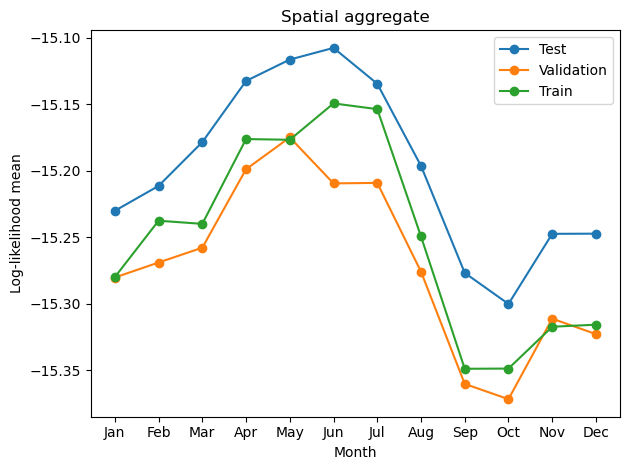

In [54]:
var = "log_likelihood_mean"
label = "Log-likelihood mean"

fig, ax = plot_spatial_mean(ll_hist_1d_train_ds[var], ll_hist_1d_val_ds[var], ll_hist_1d_test_ds[var], label)
plt.show()

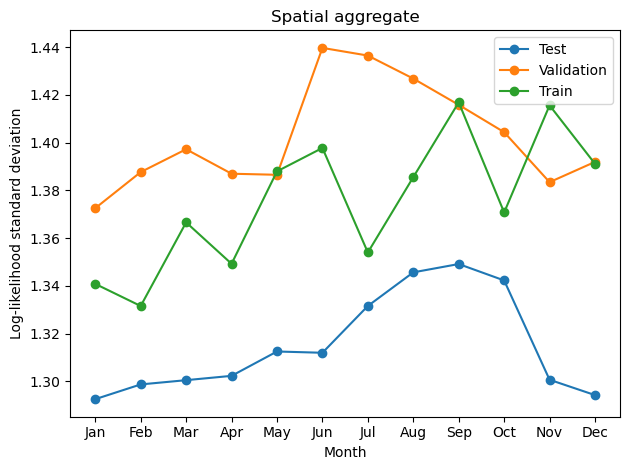

In [55]:
var = "log_likelihood_std"
label = "Log-likelihood standard deviation"

fig, ax = plot_spatial_mean(ll_hist_1d_train_ds[var], ll_hist_1d_val_ds[var], ll_hist_1d_test_ds[var], label)
plt.show()

### Test set

In [23]:
var = "log_likelihood_mean"

vmin = vmin_mean
vmax = vmax_mean

label = "Test set log-likelihood mean"

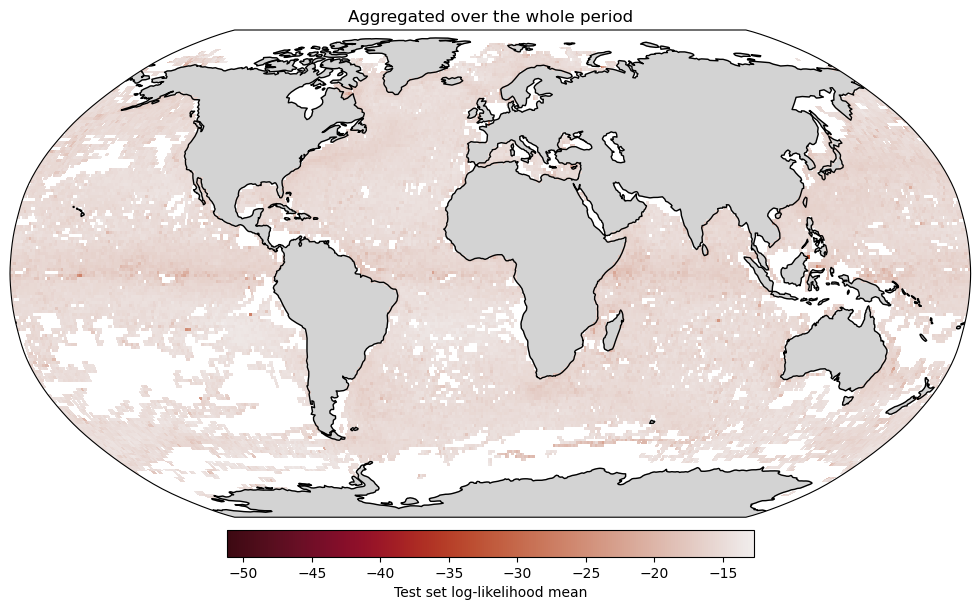

In [25]:
fig, ax = plot_annual_mean_field(ll_hist_2d_test_ds[var], cmo.amp_r, vmin, vmax, label)
plt.show()

In [26]:
fig, anim, video = plot_annual_movie(ll_hist_3d_test_ds[var], cmo.amp_r, vmin, vmax, label)
plt.close(fig)

video

In [27]:
var = "log_likelihood_std"

vmin = vmin_std
vmax = vmax_std

label = "Test set log-likelihood standard deviation"

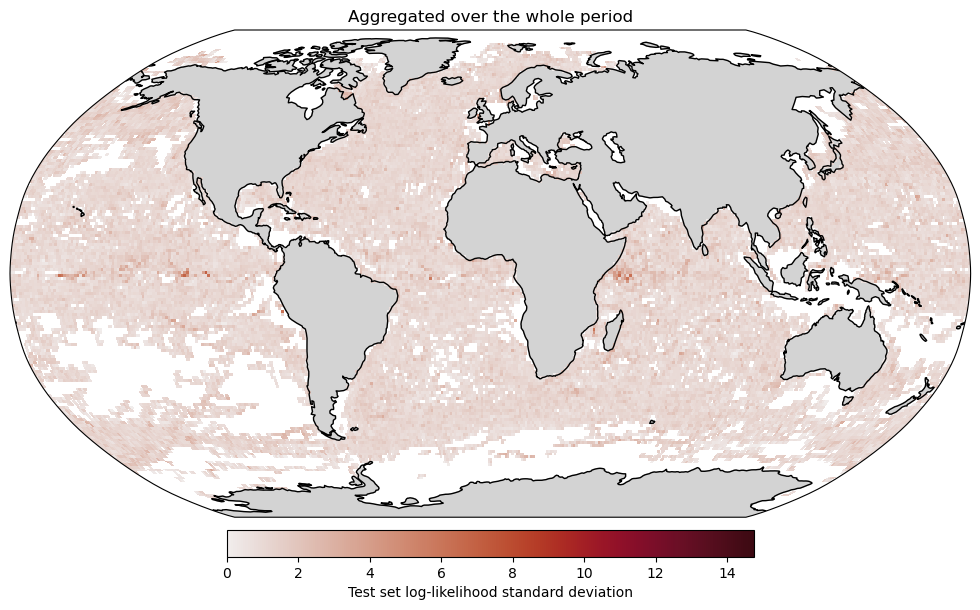

In [29]:
fig, ax = plot_annual_mean_field(ll_hist_2d_test_ds[var], cmo.amp, vmin, vmax, label)
plt.show()

In [30]:
fig, anim, video = plot_annual_movie(ll_hist_3d_test_ds[var], cmo.amp, vmin, vmax, label)
plt.close(fig)

video

### Validation set

In [31]:
var = "log_likelihood_mean"

vmin = vmin_mean
vmax = vmax_mean

label = "Validation set log-likelihood mean"

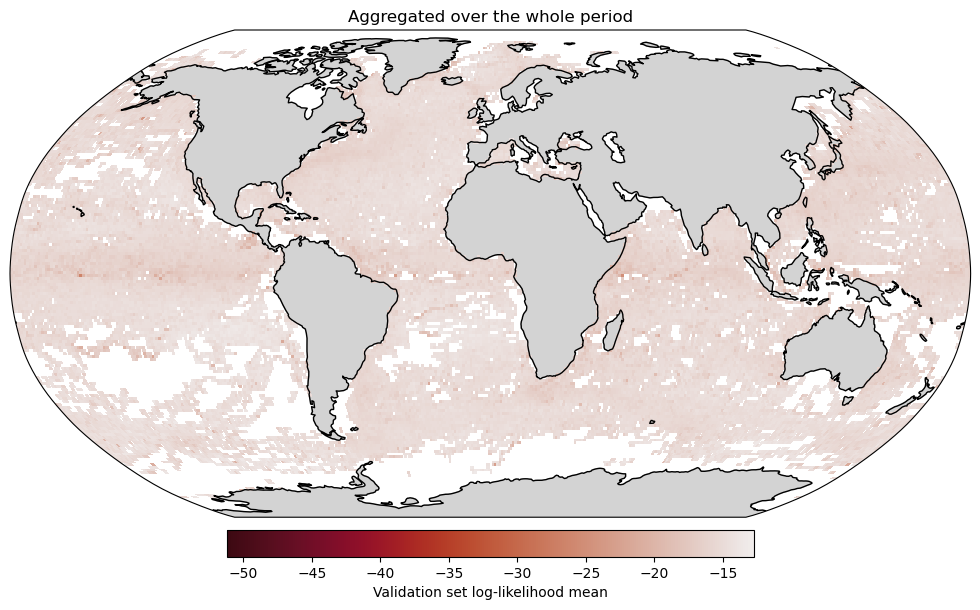

In [33]:
fig, ax = plot_annual_mean_field(ll_hist_2d_val_ds[var], cmo.amp_r, vmin, vmax, label)
plt.show()

In [34]:
fig, anim, video = plot_annual_movie(ll_hist_3d_val_ds[var], cmo.amp_r, vmin, vmax, label)
plt.close(fig)

video

In [35]:
var = "log_likelihood_std"

vmin = vmin_std
vmax = vmax_std

label = "Validation set log-likelihood standard deviation"

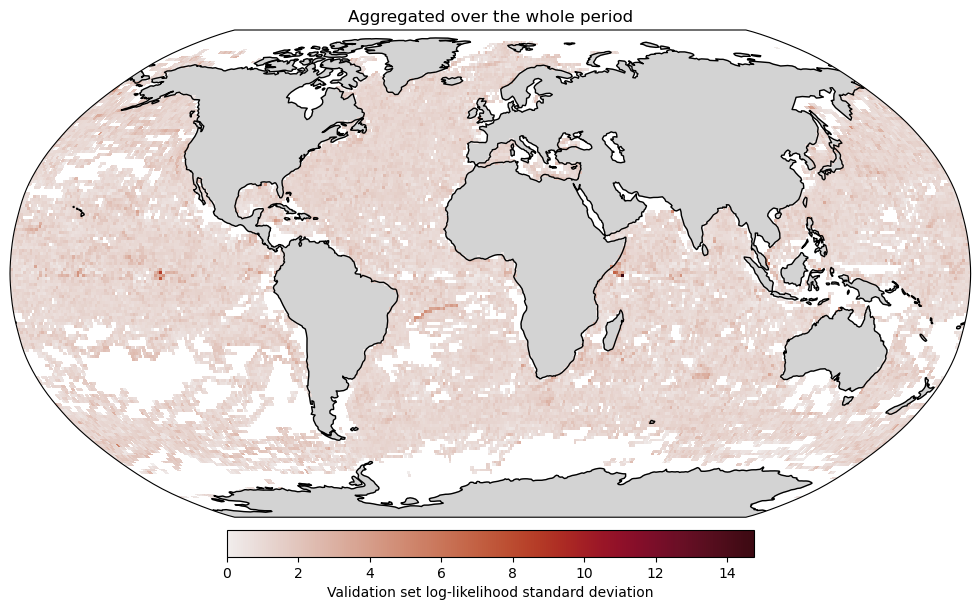

In [37]:
fig, ax = plot_annual_mean_field(ll_hist_2d_val_ds[var], cmo.amp, vmin, vmax, label)
plt.show()

In [38]:
fig, anim, video = plot_annual_movie(ll_hist_3d_val_ds[var], cmo.amp, vmin, vmax, label)
plt.close(fig)

video

### Training set

In [39]:
var = "log_likelihood_mean"

vmin = vmin_mean
vmax = vmax_mean

label = "Training set log-likelihood mean"

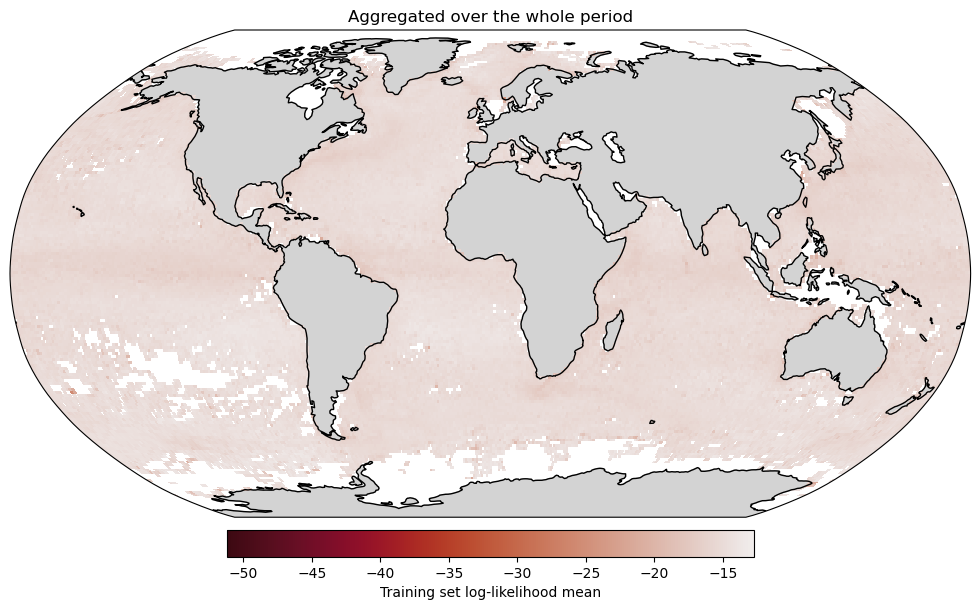

In [41]:
fig, ax = plot_annual_mean_field(ll_hist_2d_train_ds[var], cmo.amp_r, vmin, vmax, label)
plt.show()

In [42]:
fig, anim, video = plot_annual_movie(ll_hist_3d_train_ds[var], cmo.amp_r, vmin, vmax, label)
plt.close(fig)

video

In [43]:
var = "log_likelihood_std"

vmin = vmin_std
vmax = vmax_std

label = "Training set log-likelihood standard deviation"

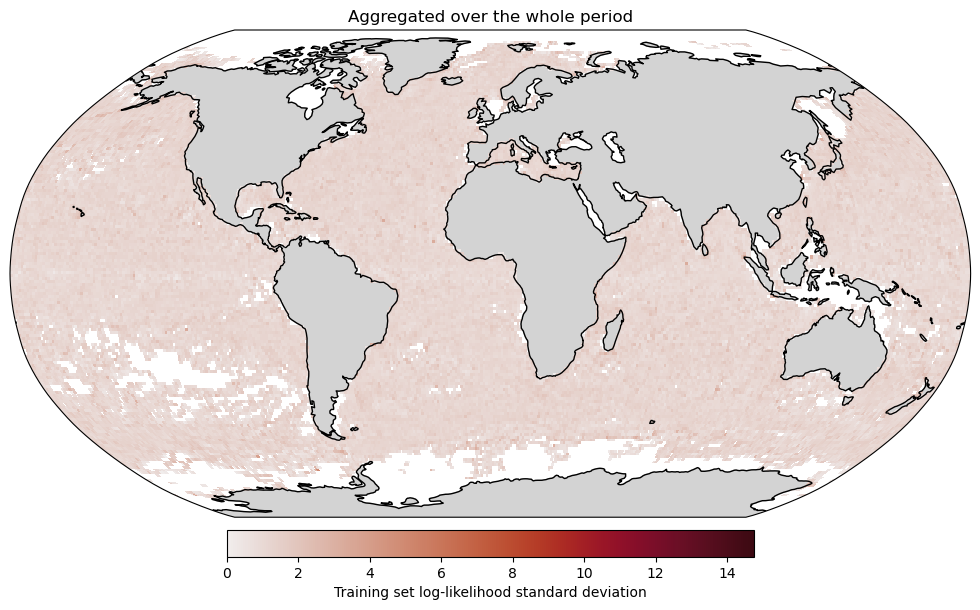

In [45]:
fig, ax = plot_annual_mean_field(ll_hist_2d_train_ds[var], cmo.amp, vmin, vmax, label)
plt.show()

In [46]:
fig, anim, video = plot_annual_movie(ll_hist_3d_train_ds[var], cmo.amp, vmin, vmax, label)
plt.close(fig)

video